## EDA

This notebook is a first look at the data. <br>
Its supposed to validate the data, identify any possible issues and provide insights for feature engineering and data pre processingm. <br>

In [1]:
from glob import glob

import pandas as pd
import numpy as np

There seems to be two different file types.

summary.csv a single file <br>
and  <br>
day_#.csv, 50 different files <br>

lets take a first look on each.

In [2]:
day_files = glob('../data/day*')

In [3]:
summary = pd.read_csv('../data/summary.csv')
summary.head(3)

,Unnamed: 0,arrival_time,assessment_end_time,assessment_start_time,consultation_end_time,consultation_start_time,day,duration,pain,patient,priority,temperature
0,0,430,1055,878,1595,1084,1,510,severe pain,3,normal,36.8
1,1,280,741,308,1620,773,1,847,no pain,1,urgent,36.6
2,2,288,851,764,1881,905,1,976,severe pain,2,normal,36.7


In [4]:
np.random.seed(42)

random_day = pd.read_csv('../data/day {}.csv'.format(int(np.random.randint(1,50))))
random_day.head(10)

,Unnamed: 0,assessment,day,event,patient,time
0,0,NaN,39,arrived,3253,68
1,1,NaN,39,assessment initiated,3253,100
2,2,NaN,39,arrived,3254,150
3,3,normal|36.8|no pain,39,assessment concluded,3253,226
4,4,NaN,39,consultation_initiated,3253,261
5,5,NaN,39,assessment initiated,3254,277
6,6,NaN,39,arrived,3255,294
7,7,NaN,39,arrived,3256,316
8,8,normal|36.599999999999994|no pain,39,assessment concluded,3254,412
9,9,NaN,39,assessment initiated,3255,434


Both files have an unnecessary index column (pd.to_csv('...', index=False) was not set). <br>
Day files seem to have a day column which makes life easier when concating different files into one large data set. <br>
Its unclear at first sight if feature patient at summary has a numerical id that resets at each day, or if its cummulative, one must check. <br>
Summary seems to give the overall summary of each pacient visit: the day, arrival time, start time, end time, priority, temperature, duration (in regard to consultation, with rounding applied, while the consultation values are int) <br>
The day files seem unnecessary. assessment information, day value, event time is all recorded on summary. <br>
It would however make sense to double check for data integrity among both data sets. <br>

In [5]:
days = pd.concat([pd.read_csv(file_path, index_col=['Unnamed: 0']) for file_path in day_files],0, ignore_index=True)

In [6]:
assert sorted(days['day'].unique()) == sorted(summary['day'].unique())
assert sorted(days['patient'].unique()) == sorted(summary['patient'].unique())

unique days entries and unique patient entries are equal on both files

In [7]:
temp = days[['patient','event','time']].sort_values(['patient','time'])

dictionary = {'arrived':0,'assessment initiated':1,'assessment concluded':2,'consultation_initiated':3,'consultation_finished':4}

temp['value'] = temp['event'].map(dictionary)

temp[:10]

,patient,event,time,value
0,1,arrived,280,0
2,1,assessment initiated,308,1
4,1,assessment concluded,741,2
6,1,consultation_initiated,773,3
21,1,consultation_finished,1620,4
1,2,arrived,288,0
5,2,assessment initiated,764,1
7,2,assessment concluded,851,2
9,2,consultation_initiated,905,3
25,2,consultation_finished,1881,4


notation is not standard. assessment uses spaces // consultation uses underlines. <br>
is it possible that patients do not have all 5 steps (arrive // assessment init // assessment conc // consultation init // consultation conc)? <br>
is it possible that some entries are missplaced in order (consultation before assessment)?

In [8]:
print (sum(temp.groupby('patient').apply(len)!=5))
print (sum(temp.groupby('patient').agg({'event':'nunique'})['event']!=5))

temp['value_shift'] = temp.groupby('patient')['value'].shift(-1)

print (temp.loc[(temp['value']<temp['value_shift'])|(temp['value_shift'].isnull())].shape == temp.shape)

0
0
True


Okay lets recap. <br>
Data seems to have integrity! <br>
"summary" seems to have all data present in "days" files. <br>

we have not yet checked if the values present on days are equal to those on summary (in regard to timestamps for events/users). <br>
we also need to do a statiscal analysis of data for insights/issues.

In [9]:
days_copy = days.copy()
days_copy.drop(['assessment'],1,inplace=True)
days_copy = days_copy[['patient','day','event','time']]
days_copy = pd.pivot_table(days_copy, columns=['event'], values=['time'], index=['patient','day']).reset_index()
days_copy.columns = ['patient','day','arrival_time','assessment_end_time','assessment_start_time','consultation_end_time','consultation_start_time']
days_copy = days_copy.sort_values(['day','patient','arrival_time'])

days_copy[:5]

,patient,day,arrival_time,assessment_end_time,assessment_start_time,consultation_end_time,consultation_start_time
0,1,1,280,741,308,1620,773
1,2,1,288,851,764,1881,905
2,3,1,430,1055,878,1595,1084
3,4,1,944,1244,1089,2105,1294
4,5,1,1139,1351,1267,3322,1378


In [10]:
summary_copy = summary.copy()
summary_copy = summary_copy[['patient','day','arrival_time','assessment_end_time','assessment_start_time','consultation_end_time','consultation_start_time']]
summary_copy = summary_copy.sort_values(['day','patient','arrival_time'])

summary_copy[:5]

,patient,day,arrival_time,assessment_end_time,assessment_start_time,consultation_end_time,consultation_start_time
1,1,1,280,741,308,1620,773
2,2,1,288,851,764,1881,905
0,3,1,430,1055,878,1595,1084
3,4,1,944,1244,1089,2105,1294
11,5,1,1139,1351,1267,3322,1378


In [11]:
print (summary_copy.shape)
print (days_copy.shape)

(4420, 7)
(4420, 7)


In [12]:
(summary_copy.values == days_copy.values).all()

True

Great! the values check out! the information in summary is the same as in the days files. <br>

Now lets get on to the graphical analysis! 

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

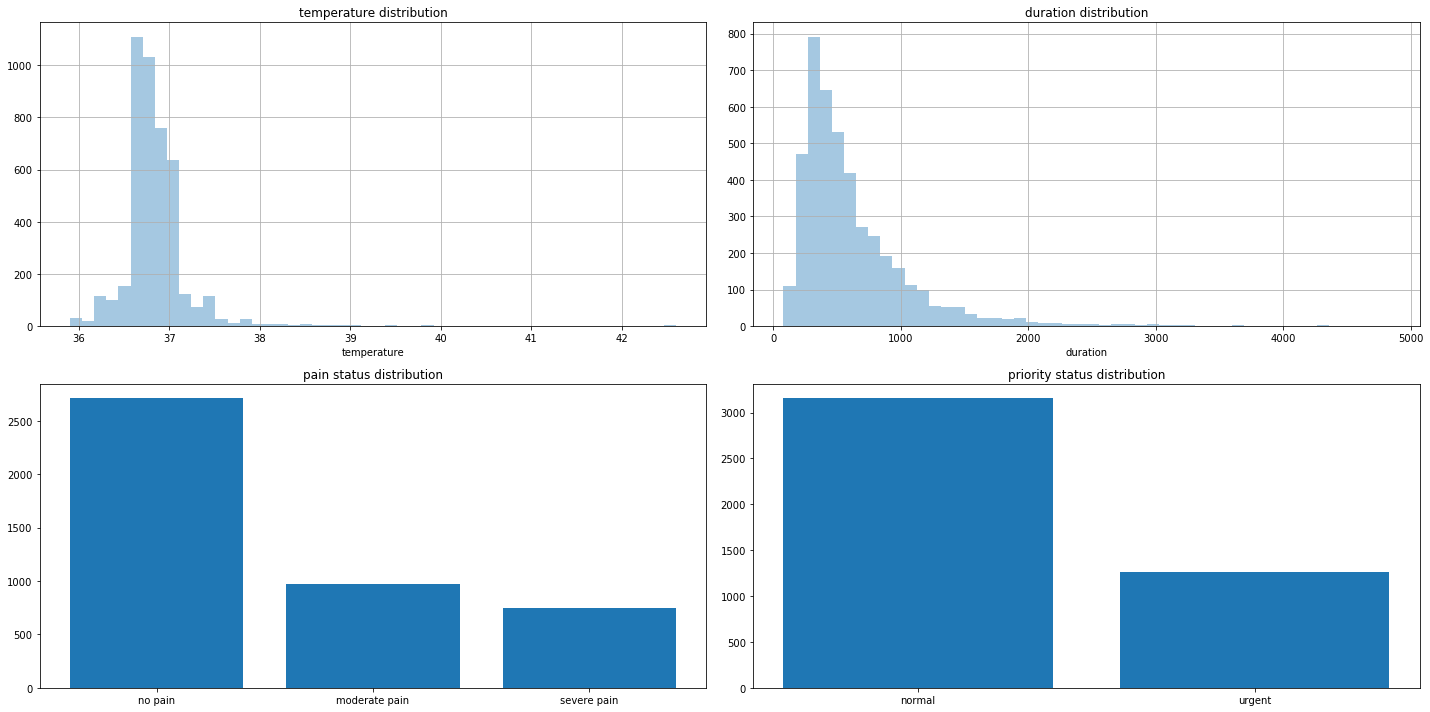

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.distplot(summary['temperature'], kde=False)
plt.title('temperature distribution')
plt.grid()

plt.subplot(222)
sns.distplot(summary['duration'], kde=False)
plt.title('duration distribution')
plt.grid()

plt.subplot(223)

data = summary['pain'].value_counts()
X = np.arange(len(data))
y = data.values

plt.bar(X,y)
plt.xticks(X, data.index)
plt.title('pain status distribution')

plt.subplot(224)

data = summary['priority'].value_counts()
X = np.arange(len(data))
y = data.values

plt.bar(X,y)
plt.xticks(X, data.index)
plt.title('priority status distribution')

plt.tight_layout()

target distribution is skewed. thats bad for regression models. <br>

In [15]:
summary_corr = summary[['duration','arrival_time','assessment_start_time','assessment_end_time','pain','priority','temperature']].copy()
summary_corr = pd.concat([summary_corr.drop('priority',1), pd.get_dummies(summary_corr['priority'], prefix='priority')],1)
summary_corr = pd.concat([summary_corr.drop('pain',1), pd.get_dummies(summary_corr['pain'], prefix='pain')],1)
summary_corr = summary_corr.corr()

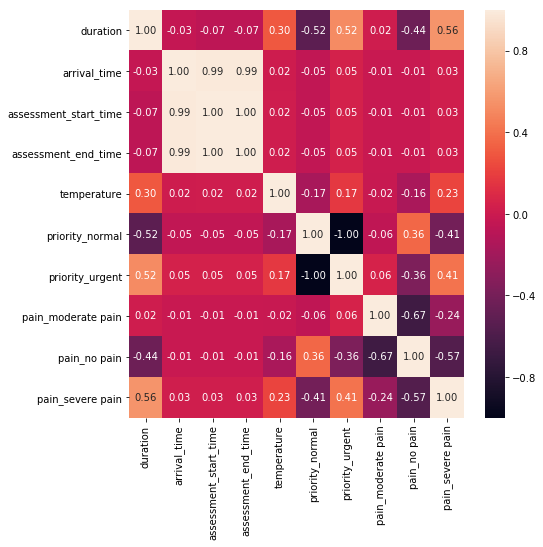

In [16]:
plt.figure(figsize=(7.5,7.5))
sns.heatmap(summary_corr, vmin=-1, vmax=1, annot=True, fmt='.2f')

as one would expect, the target (duration) is highly related to temperature / pain / priority. <br>

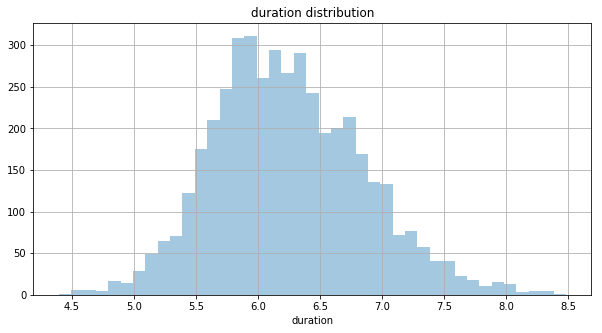

In [17]:
plt.figure(figsize=(10,5))
sns.distplot(np.log(summary['duration']), kde=False)
plt.title('duration distribution')
plt.grid()

a simple log transform makes the target close to a normal distribution.